### In this notebook the effects of filtering on the cross correlation are analysed

#### Importing libraries

In [28]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.fft import fft, ifft, ifftshift, rfft

#### Defining paths

In [29]:
data_path =  r"..\data\avstand_1.npz"

#### Defining Cross Correlation Parameters

In [30]:
numtaps = 1001
truncate_length = 60
window_type = signal.windows.boxcar
beta = 0
correlation_type = np.real
band_width = 1000
frequencies = np.linspace(1000, 40000, 100)
sampling_rate = 204800 #Hz
num_samples = 204800

#### Loading data 

In [31]:
data = np.load(data_path)['data']

#### Defining the two system noise variables we will analyse in this notebook

In [32]:
sensor_1 = data[0][:num_samples]
sensor_2 = data[1][:num_samples]

#### Defining Cross Correlation Functions

In [33]:
filters = []
# creating filters bandpass
for frequency in frequencies:
    h = signal.firwin(numtaps, [frequency - band_width//2, frequency + band_width//2], fs=sampling_rate, pass_zero="bandpass")
    filters.append(h)

def truncate_time_shift(time_shift,length):
    index_0 = len(time_shift)/2
    start_index = int(index_0 - length/2)
    end_index = int(index_0 + length/2)
    time_shift = time_shift[start_index:end_index]
    return time_shift

def GCC(sensor1, sensor2): 
    GCC_12 = []
    i = 0 
    for h in filters:
        s1 = signal.lfilter(h, 1.0, sensor1)
        s2 = signal.lfilter(h, 1.0, sensor2)

        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        denom[denom < 1e-6] = 1e-6
        f_s = G12 / denom**beta


        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)
    GCC_12 = np.array(GCC_12)
    return GCC_12


#### GCC creation

In [34]:
GCC_12 = GCC(sensor_1, sensor_2)
GCC_11 = GCC(sensor_1, sensor_1)
GCC_22 = GCC(sensor_2, sensor_2)
GCC_21 = GCC(sensor_2, sensor_1)

#### Creating the time_shifts 

In [35]:
dt = 1 / sampling_rate
time_shifts = np.arange(-num_samples*dt,num_samples*dt,dt)
time_shifts = truncate_time_shift(time_shifts, truncate_length)

#### Plotting the magnitude and fase information of the system signal



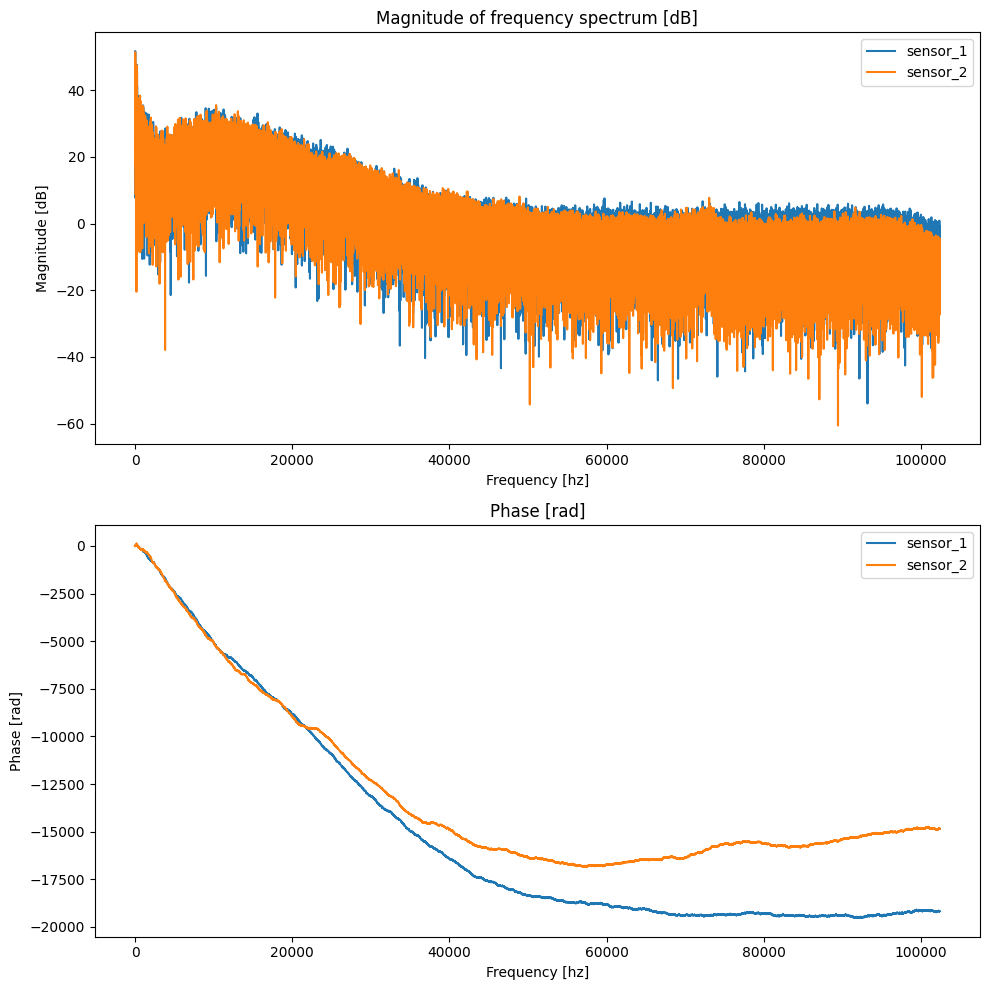

In [36]:
fft_sensor_1 = rfft(sensor_1)[1:]
fft_sensor_2 = rfft(sensor_2)[1:]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax = ax.ravel()

ax[0].plot(np.log10(np.abs(fft_sensor_1))*20, label = "sensor_1")
ax[0].plot(np.log10(np.abs(fft_sensor_2))*20, label = "sensor_2")
ax[0].set_title("Magnitude of frequency spectrum [dB]")
ax[0].set_xlabel("Frequency [hz]")
ax[0].set_ylabel("Magnitude [dB]")


ax[1].plot(np.unwrap(np.angle(fft_sensor_1)), label = "sensor_1")
ax[1].set_title("Phase [rad]")
ax[1].plot(np.unwrap(np.angle(fft_sensor_2)), label = "sensor_2")
ax[1].set_xlabel("Frequency [hz]")
ax[1].set_ylabel("Phase [rad]")


ax[0].legend()
ax[1].legend()

fig.tight_layout()



#### Cross Correlation of the system noise for different frequency filters

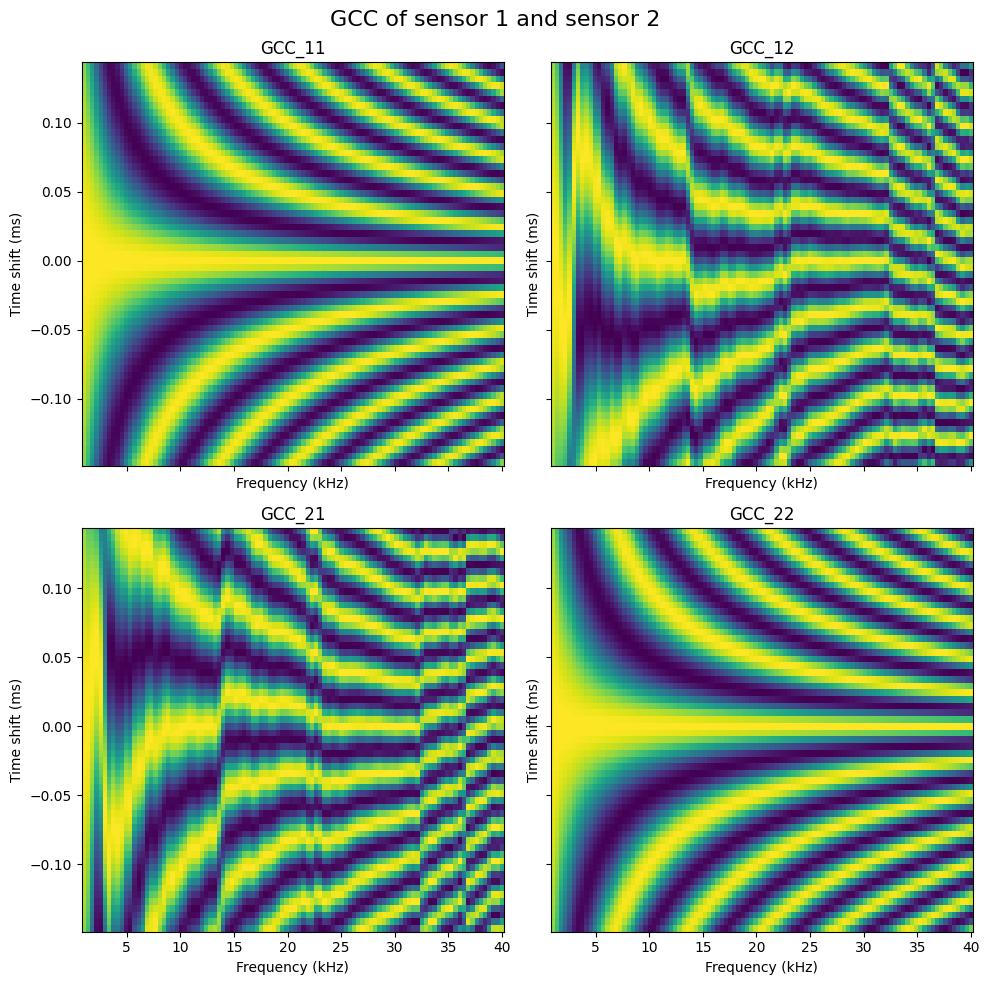

In [37]:
fig, ax = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
ax = ax.ravel()


ax[1].pcolormesh(frequencies/1000, time_shifts*1000, GCC_12.T, shading='auto')
ax[1].set_title('GCC_12')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Time shift (ms)')

ax[0].pcolormesh(frequencies/1000, time_shifts*1000, GCC_11.T, shading='auto')
ax[0].set_title('GCC_11')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Time shift (ms)')

ax[3].pcolormesh(frequencies/1000, time_shifts*1000, GCC_22.T, shading='auto')
ax[3].set_title('GCC_22')
ax[3].set_xlabel('Frequency (kHz)')
ax[3].set_ylabel('Time shift (ms)')

ax[2].pcolormesh(frequencies/1000, time_shifts*1000, GCC_21.T, shading='auto')
ax[2].set_title('GCC_21')
ax[2].set_xlabel('Frequency (kHz)')
ax[2].set_ylabel('Time shift (ms)')


fig.suptitle('GCC of sensor 1 and sensor 2', fontsize=16)

fig.tight_layout()
